<a href="https://colab.research.google.com/github/EmmanuelJhno/Reinforcement_learning/blob/master/TP2_bandits_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
class BernoulliBanditEnv(object): 
    # Class that defines the environment with reward 0 and 1 with probability p.

    def __init__(self, num_arms=10, p=None):
        self.num_arms = num_arms
        self.actions = np.arange(num_arms)     # define set of actions

        if len(p)==1:
            self.p = np.random.beta(0.5, 0.5, size=num_arms)
        elif len(p) == num_arms:
            self.p = p
        else:
            raise Exception('Number of probabilities ({}) does not correspond to number of arms ({}).'.format(len(q), num_arms))
        self.best_action = np.argmax(self.p)   # Best action given env

    def reward(self, action):
        return np.random.binomial(1, p=self.p[action])


In [0]:
class Agent(object):
    # Class which defines the agent. Each aganet has a decision rule and a learning rule.
    
    def __init__(self, learning_rule, decision_rule, param=None):
        self.decision_rule = decision_rule
        self.learning_rule = learning_rule

        if decision_rule == "epsilon-greedy":
            self.epsilon = param["epsilon"]
        
        if decision_rule == "UCB":
            self.UCB_param = param["UCB_param"]
        
        if decision_rule == "Thompson":
            self.learning_rule = "BayesianBetaPrior"
    
    def environment(self, env, init_q):
        # initialize environment
        self.env = env                                  
        self.k = env.num_arms                           
        self.actions = np.arange(self.k)                
        self.act_count = np.zeros(self.k)               
        self.iteration = 0     
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha = np.random.uniform(size=self.k)
            self.beta = np.random.uniform(size=self.k)
        if len(init_q) == self.k:
            self.q_estimate = init_q
        else:
            raise Exception('Number of initial values ({}) does not correspond to number of arms ({}).'.format(len(init_q), self.k))

    def learn(self, a, r):
        # given action and reward, update value function.
        if self.learning_rule == "averaging":
            self.q_estimate[a] += 1/self.act_count[a] * (r - self.q_estimate[a])
            
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha[a] += r
            self.beta[a] += 1 - r 
            
    def act(self):
        # action.
        self.iteration += 1 
        if self.decision_rule == "greedy":
            if self.learning_rule == "averaging":
                selected_action = np.argmax(self.q_estimate)
            elif self.learning_rule == "BayesianBetaPrior":
                theta = self.alpha / (self.alpha + self.beta)
                selected_action = np.argmax(theta)

        if self.decision_rule == "epsilon-greedy":
            if np.random.rand() <= self.epsilon:
                selected_action =  np.random.randint(0, self.k)
            else:
                if self.learning_rule == "averaging":
                    selected_action = np.argmax(self.q_estimate)
                elif self.learning_rule == "BayesianBetaPrior":
                    theta = self.alpha / (self.alpha + self.beta)
                    selected_action = np.argmax(theta)
        
        if self.decision_rule == "UCB":
            eps_t = np.sqrt(2 * np.log(self.iteration) / (self.act_count + 1))
            if self.learning_rule == "averaging":
                selected_action = np.argmax(self.q_estimate + eps_t)
            elif self.learning_rule == "BayesianBetaPrior":
                theta = self.alpha / (self.alpha + self.beta)
                selected_action = np.argmax(theta + eps_t)
        
        if self.decision_rule == "Thompson":
            probs = [np.random.beta(self.alpha[a], self.beta[a], 1) for a in self.actions]
            selected_action = np.argmax(probs)
            
        self.act_count[selected_action] += 1
        return selected_action

In [0]:
def simulateBandits(agents, narms, initp=None, initq=None, repetitions=1000, N=100):
    # function that simulates the agents behaviour
    # agents is a list of agents.
    
    rewards = np.zeros((len(agents), repetitions, N))
    bestarm = np.zeros((len(agents), repetitions, N))
    for i, agent in enumerate(agents):
        for j in np.arange(repetitions):
            environment = BernoulliBanditEnv(num_arms=narms, p=initp)
            agent.environment(environment, initq if not(initq == None) else np.zeros(narms))
            for n in np.arange(N):
                a = agent.act()
                r = environment.reward(a)
                agent.learn(a, r)
                rewards[i, j, n] = r
                bestarm[i, j, n] = 1 if a == environment.best_action else 0
    return np.squeeze(np.mean(rewards, axis=1)), np.squeeze(np.mean(bestarm, axis=1))

In [0]:
def plot_results(agents, actions, rewards):
    assert len(agents) == actions.shape[0] == rewards.shape[0]
    ax1 = None; ax2 = None; ax3 = None
    for i in reversed(range(len(agents))):
        agent = agents[i]
        mean_rewards = rewards[i]
        bestarm = actions[i]
        cum_rewards = np.cumsum(mean_rewards)
        
        if ax1 is None:
            ax1 = plt.subplot(3, len(agents), i + 1)
        else:
            plt.subplot(3, len(agents), i+1, sharey=ax1)
        plt.plot(mean_rewards, label="Mean rewards")
        plt.xlabel("timestep")
        plt.ylabel("reward")
        title = "Agent #{}\ndecision rule: {}".format(i, agent.decision_rule)
        if agent.decision_rule == "epsilon-greedy":
            title += "\nespilon: {}".format(agent.epsilon)
        plt.title(title)
        plt.grid()
        plt.legend()
        
        if ax2 is None:
            ax2 = plt.subplot(3, len(agents), len(agents) + i + 1)
        else:
            plt.subplot(3, len(agents),  len(agents) + i + 1, sharey=ax2)
        plt.plot(cum_rewards, label="Mean cumulated rewards")
        plt.xlabel("timestep")
        plt.ylabel("reward")
        plt.grid()
        plt.legend()
        
        if ax3 is None:
            ax3 = plt.subplot(3, len(agents), 2 * len(agents) + i + 1)
        else:
            plt.subplot(3, len(agents),  2 * len(agents) + i + 1, sharey=ax3)
        plt.plot(bestarm, label="Percentage of best arm selected")
        plt.xlabel("timestep")
        plt.ylabel("percentage")
        plt.grid()
        plt.legend()
    plt.tight_layout()
    plt.show()

# Exercises:

1) COMPLETE the code where it says "COMPLETE".

2) Do simulations for a bandit with 2 arms P = [0.4, 0.8] for each of the mentionned decision rule and plot the corresponding  mean reward; the mean cumulative reward and the percentage of times the best arm was elected as time goes by. Interpret. 


3) Do simulations with a bandit with 10 arms (P = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]). Plot the corresponding  mean reward; the mean cumulative reward and the percentage of times the best arm was elected as time goes by. Interpret.  

4) Study the dependence of the hyperparameter epsilon in the decision rule epsilon-greedy.


In [0]:
greedy_agent = Agent(learning_rule="averaging", decision_rule="greedy")
eps_greedy_agent = Agent(learning_rule="averaging", decision_rule="epsilon-greedy",
                        param={"epsilon": 0.1})
ucb_agent = Agent(learning_rule="averaging", decision_rule="UCB", param={"UCB_param": None})
thompson_agent = Agent(learning_rule="BayesianBetaPrior", decision_rule="Thompson")
agents=[greedy_agent, eps_greedy_agent, ucb_agent, thompson_agent]

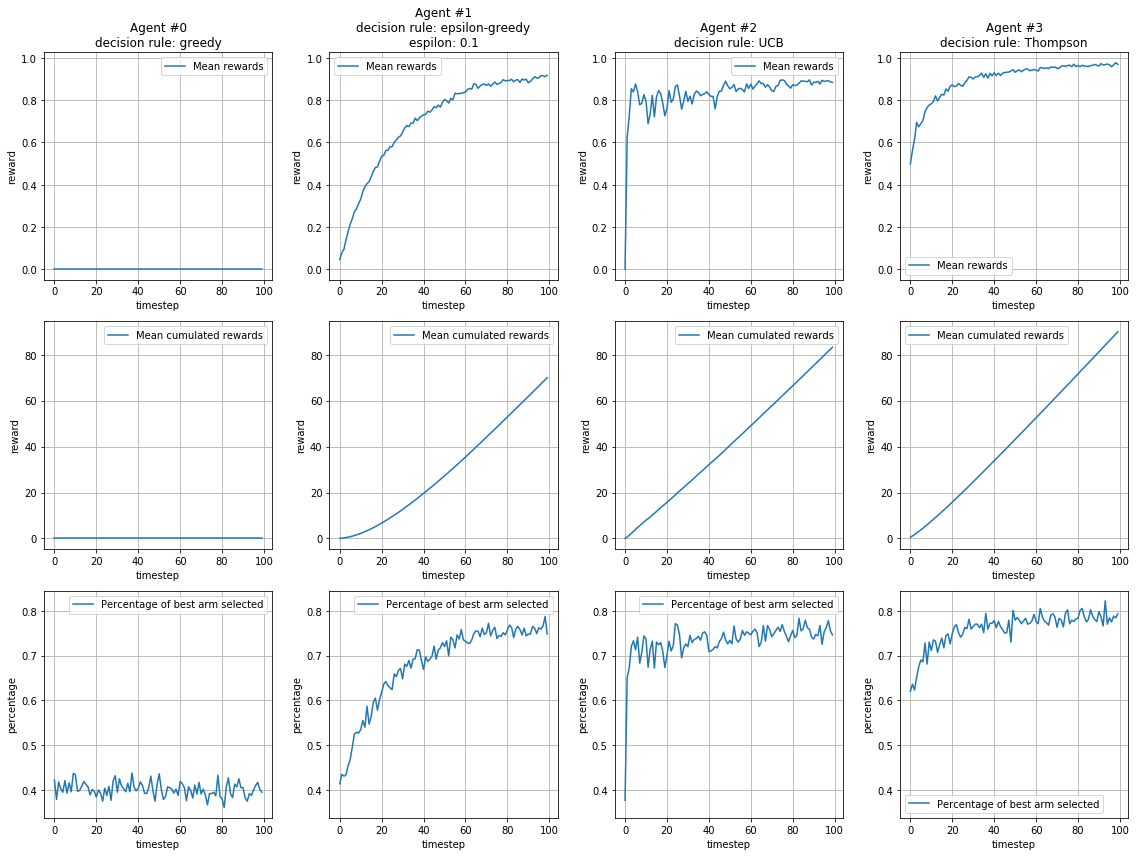

In [8]:
rewards, actions = simulateBandits(agents=agents, narms=2, initp=[0.4, 0.8])

plt.figure(figsize=(16, 12))
plot_results(agents, rewards, actions)

As expected, the naive (greedy) approach performs far worse than the others.

The epsilon-greedy approach performs better when time goes by, illustrating the exploration/exploitation trade off.

The UCB approach has very good results very fast in this con figuration, but the Bayesian approach based on Thompson sampling is thge one that performs best.

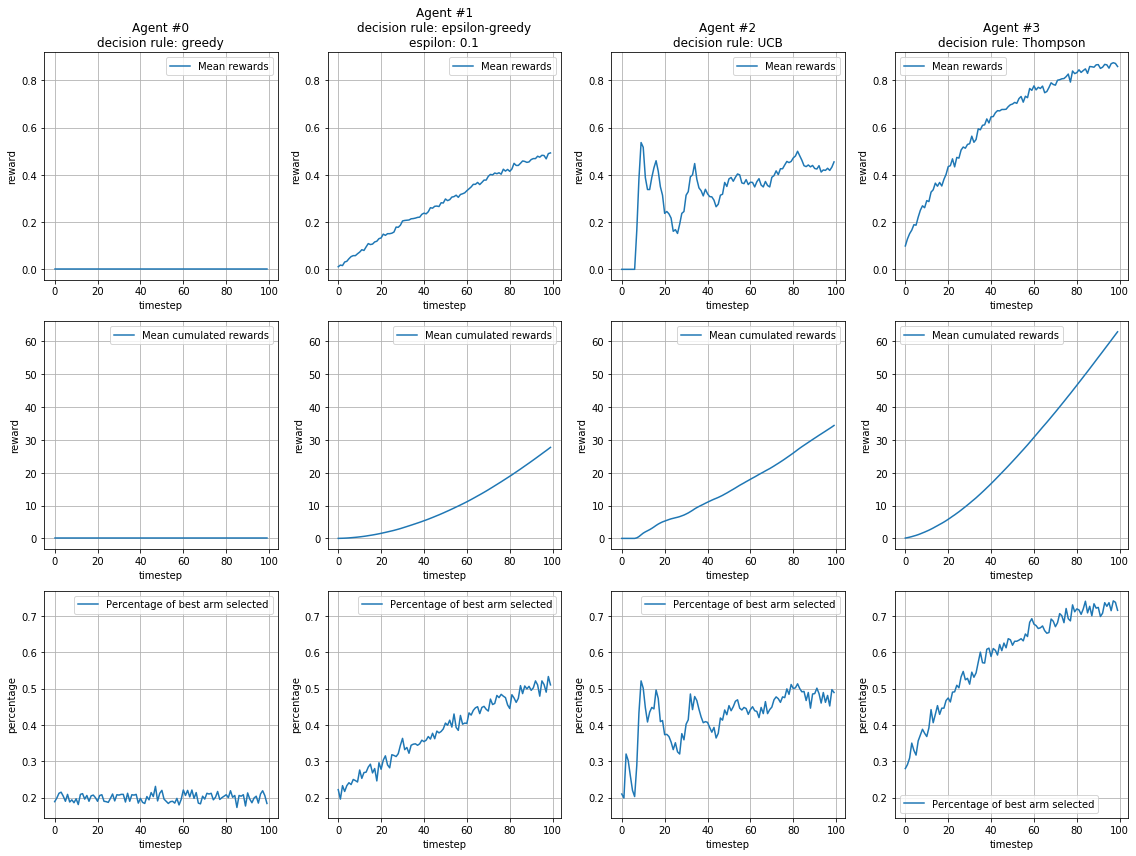

In [9]:
rewards, actions = simulateBandits(agents=agents, narms=10, initp=[0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2])

plt.figure(figsize=(16, 12))
plot_results(agents, rewards, actions)

We observe results similar to the 2-arms bandit experience.

UCB has a very high variance in terms of mean rewards and best arm selected.

The Bayesian approach with Thompson sampling has better results faster than the other methods !

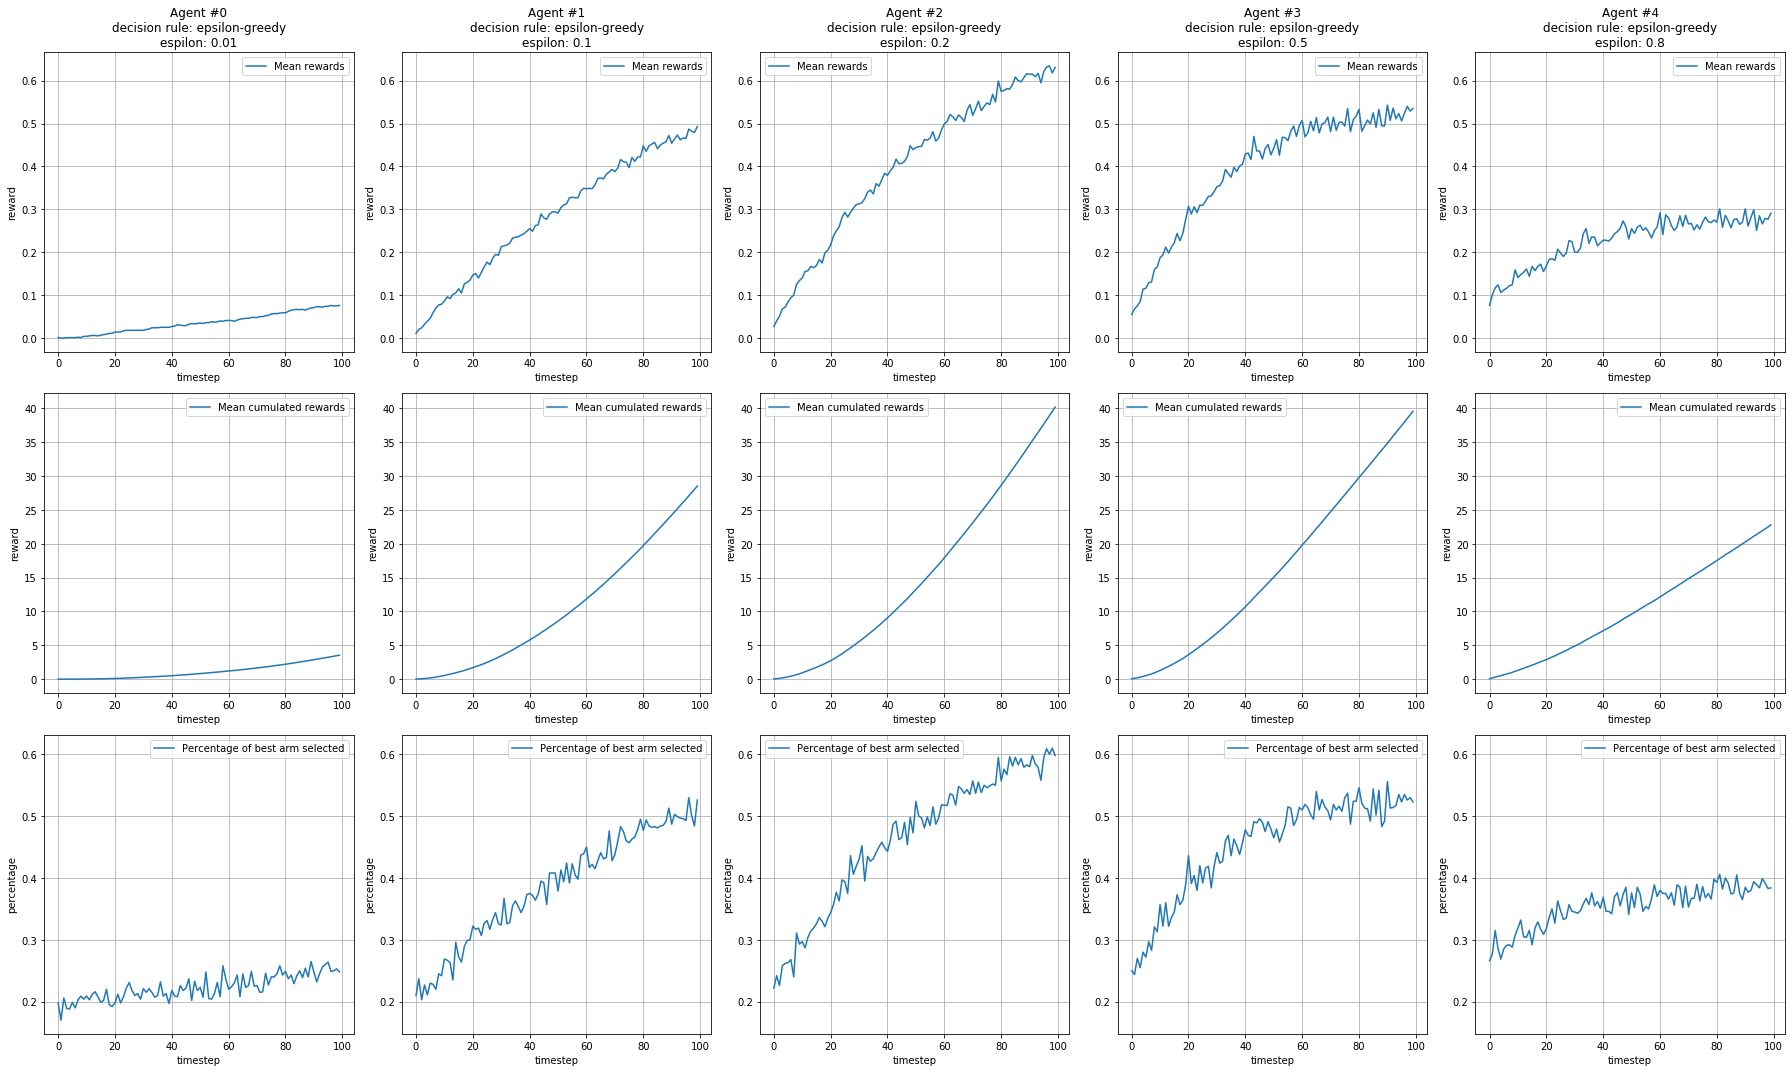

In [10]:
epsilons = [0.01, 0.1, 0.2, 0.5, 0.8]

agents = [Agent(learning_rule="averaging", decision_rule="epsilon-greedy", param={"epsilon": eps}) for eps in epsilons]
rewards, actions = simulateBandits(agents=agents, narms=10, initp=[0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2])

plt.figure(figsize=(25, 15))
plot_results(agents, rewards, actions)

This experience illustrates the trade-off between exploration and exploitation: too small and too big epsilons both hurt performances of the Agent.

In this specific case, the best parameter seem to be around $\epsilon = 0.2$.